In [69]:
!pip install insightface
!pip install onnxruntime
!pip install diffusers
!pip install git+https://github.com/tencent-ailab/IP-Adapter.git
!pip install einops

  Cloning https://github.com/tencent-ailab/IP-Adapter.git to /tmp/pip-req-build-66d4lr10
  Running command git clone --filter=blob:none --quiet https://github.com/tencent-ailab/IP-Adapter.git /tmp/pip-req-build-66d4lr10
  Resolved https://github.com/tencent-ailab/IP-Adapter.git to commit 62e4af9d0c1ac7d5f8dd386a0ccf2211346af1a2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [73]:
!wget -O ip-adapter_sd15.bin https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter_sd15.bin

--2024-11-18 02:12:38--  https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter_sd15.bin
Resolving huggingface.co (huggingface.co)... 3.165.160.59, 3.165.160.12, 3.165.160.11, ...
Connecting to huggingface.co (huggingface.co)|3.165.160.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.hf.co/repos/6f/e5/6fe5d8840a1ab462e1b9f52fbeabac6bb30febaf56fb5a439f08cca6d1cf4372/68e1df30d760f280e578c302f1e73b37ea08654eff16a31153588047affe0058?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27ip-adapter_sd15.bin%3B+filename%3D%22ip-adapter_sd15.bin%22%3B&response-content-type=application%2Foctet-stream&Expires=1732153658&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczMjE1MzY1OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5oZi5jby9yZXBvcy82Zi9lNS82ZmU1ZDg4NDBhMWFiNDYyZTFiOWY1MmZiZWFiYWM2YmIzMGZlYmFmNTZmYjVhNDM5ZjA4Y2NhNmQxY2Y0MzcyLzY4ZTFkZjMwZDc2MGYyODBlNTc4YzMwMmYxZTczYjM3ZWEwODY1NGVmZjE2

In [ ]:
!wget -O ip-adapter_sd15.bin https://huggingface.co/h94/IP-Adapter/resolve/main/models/ip-adapter-plus_sd15.bin

In [20]:
import torch
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline, StableDiffusionInpaintPipelineLegacy, DDIMScheduler, AutoencoderKL
from PIL import Image

from ip_adapter import IPAdapter

In [70]:
base_model_path = "runwayml/stable-diffusion-v1-5"
vae_model_path = "stabilityai/sd-vae-ft-mse"
image_encoder_path = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
#image_encoder_path = "laion/CLIP-ViT-bigG-14-laion2B-39B-b160k"
ip_ckpt = "ip-adapter_sd15.bin"
device = "cuda"

In [74]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)
vae = AutoencoderKL.from_pretrained(vae_model_path).to(dtype=torch.float16)

## Image Variations

In [75]:
# load SD pipeline
pipe = StableDiffusionPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


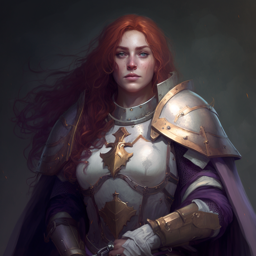

In [83]:
# read image prompt
image = Image.open("images/woman.png")
image.resize((256, 256))

In [76]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

  0%|          | 0/100 [00:00<?, ?it/s]

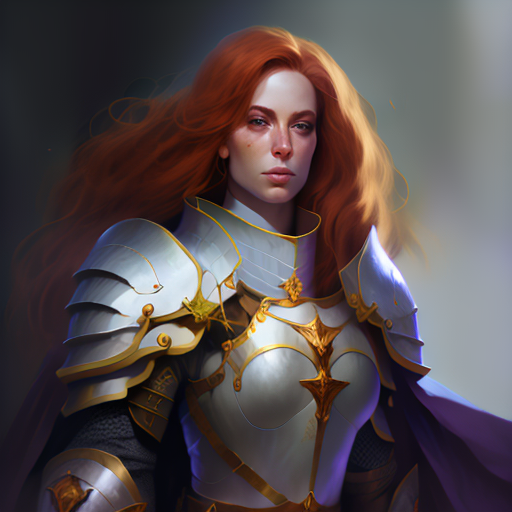

In [87]:
import random

seed = random.randint(1,9999999)

seed = seed
num_samples=1
num_inference_steps=100
guidance_scale=15
width=512
height=512

images = ip_model.generate(pil_image=image, height=height, width=width,num_samples=num_samples,num_inference_steps=num_inference_steps, seed=seed, guidance_scale=guidance_scale)
grid = image_grid(images, 1, num_samples)
grid

## Image-to-Image

In [88]:
# load SD Img2Img pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


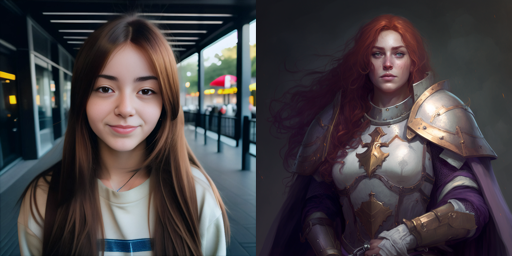

In [89]:
# read image prompt
image = Image.open("images/image.webp")
g_image = Image.open("images/woman.png")
image_grid([image.resize((256, 256)), g_image.resize((256, 256))], 1, 2)

In [90]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

/usr/local/lib/python3.10/dist-packages/ip_adapter/ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")

In [ ]:
# generate
images = ip_model.generate(pil_image=image, num_samples=1, num_inference_steps=50, seed=456456, image=g_image, strength=0.9)
grid = image_grid(images, 1, 1)
grid

## Inpainting

In [121]:
# load SD Inpainting pipe
del pipe, ip_model
torch.cuda.empty_cache()
pipe = StableDiffusionInpaintPipelineLegacy.from_pretrained(
    base_model_path,
    torch_dtype=torch.float16,
    scheduler=noise_scheduler,
    vae=vae,
    feature_extractor=None,
    safety_checker=None
)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/deprecated/stable_diffusion_variants/pipeline_stable_diffusion_inpaint_legacy.py:141: FutureWarning: The class <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> is deprecated and will be removed in v1.0.0. You can achieve exactly the same functionalityby loading your model into `StableDiffusionInpaintPipeline` instead. See https://github.com/huggingface/diffusers/pull/3533for more information.
  deprecate("legacy is outdated", "1.0.0", deprecation_message, standard_warn=False)
You have disabled the safety checker for <class 'diffusers.pipelines.deprecated.stable_diffusion_variants.pipeline_stable_diffusion_inpaint_legacy.StableDiffusionInpaintPipelineLegacy'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open t

In [122]:
# read image prompt
image = Image.open("images/image.jpg").convert("RGB")
#image.resize((256, 256))

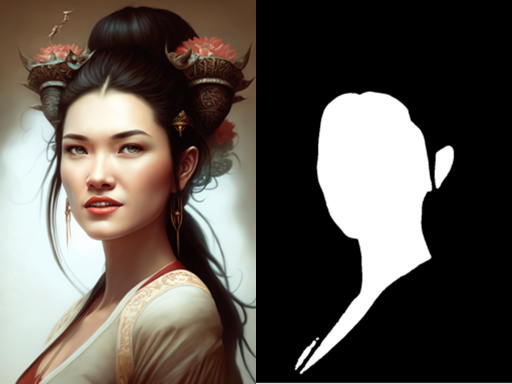

In [123]:
masked_image = Image.open("images/maked.png").resize((512, 768)).convert("RGB")
mask = Image.open("images/mask.png").resize((512, 768)).convert("RGB")
image_grid([masked_image.resize((256, 384)), mask.resize((256, 384))], 1, 2)

In [124]:
# load ip-adapter
ip_model = IPAdapter(pipe, image_encoder_path, ip_ckpt, device)

/usr/local/lib/python3.10/dist-packages/ip_adapter/ip_adapter.py:134: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(self.ip_ckpt, map_location="cpu")

In [125]:
import torch
import cv2
from insightface.app import FaceAnalysis


app = FaceAnalysis(name="buffalo_l", providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

image = cv2.imread("images/image.webp")
faces = app.get(image)

faceid_embeds = torch.from_numpy(faces[0].normed_embedding).unsqueeze(0)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [ ]:
# generate
images = ip_model.generate(pil_image=image, faceid_embeds=faceid_embeds, num_samples=1, num_inference_steps=50,
                           seed=42, image=masked_image, mask_image=mask, strength=0.7, guidance_scale=2)
grid = image_grid(images, 1, 1)
grid